In [1]:
import os
import sys
import numpy as np
import pandas as pd
import wandb
import yaml
from omegaconf import OmegaConf
from PIL import Image
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
import matplotlib.pyplot as plt
import random, math

from sklearn.model_selection import train_test_split

In [2]:
# Set up wandb key
os.environ["WANDB_API_KEY"] = "c8a7a539cb5fed3df89b21d71956ca6b4befd2a5"

config = OmegaConf.load("../config.yaml")
overrides = OmegaConf.from_cli()
config = OmegaConf.merge(config, overrides)
OmegaConf.to_container(config)
config = OmegaConf.to_container(config, resolve=True)

In [3]:
# set up device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
torch.manual_seed(config["random_state"])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config["random_state"])
    torch.cuda.manual_seed_all(config["random_state"])

## 4.2 CNN AutoEncoder (55 Marks)

### 4.2.1 Dataset Analysis and Preprocessing (10 marks)

In [5]:
def get_one_hot_encoding(label: List[int], num_classes: int=10):
    encoding = torch.zeros(num_classes)
    for digit in label:
        encoding[digit] = 1
    return encoding

def load_and_preprocess_FashionMNIST(root_dir: str):
    original_train = pd.read_csv(root_dir)
    X = original_train.iloc[:, 1:].values.reshape(-1, 28, 28)
    y = original_train['label'].values

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=config["random_state"])
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=config["random_state"])

    return X_train, X_val, X_test, y_train, y_val, y_test

def visualize_one_per_label(X, y):
    plt.figure(figsize=(15, 6))

    unique_labels = np.unique(y)

    for i, label in enumerate(unique_labels):
        idx = np.where(y == label)[0][0]
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[idx], cmap='gray')
        plt.title(f"Label {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("FashionMNIST.png")

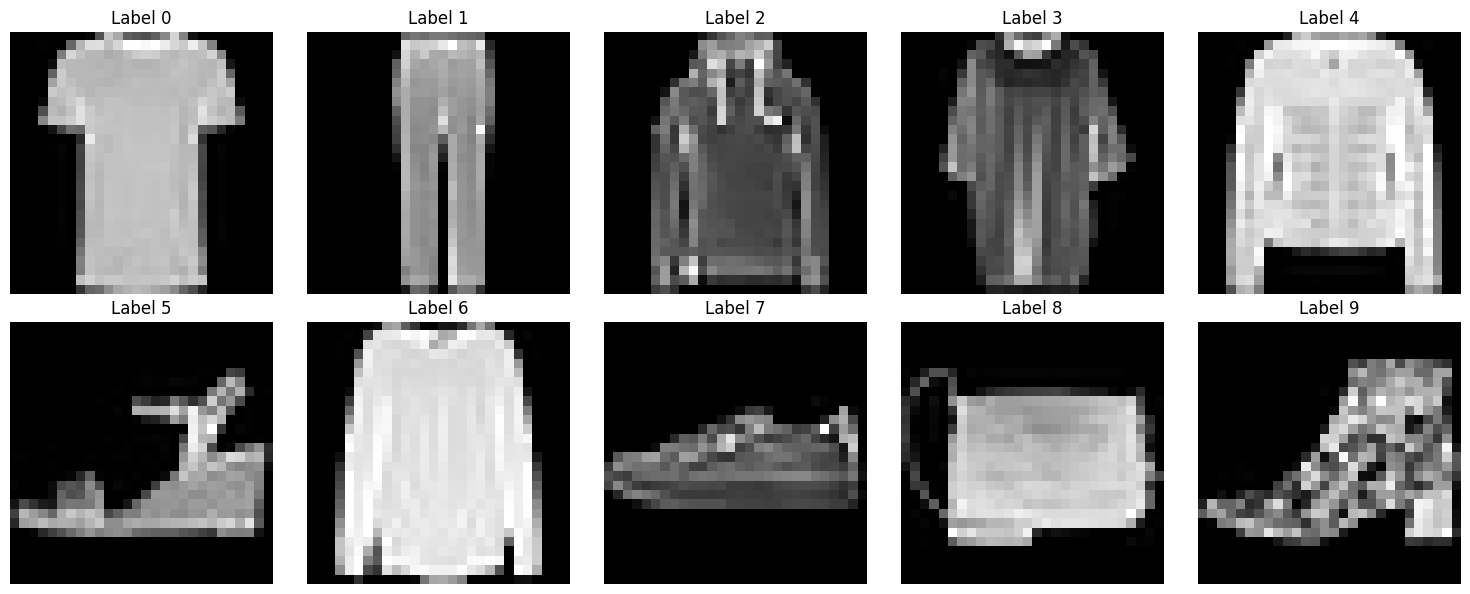

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = load_and_preprocess_FashionMNIST(config["train_folder_FashionMNIST"])
visualize_one_per_label(X_train, y_train)

### Class labels for Fashion MNIST
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle Boot'
]

In [7]:
# Print dataset information
print("Dataset Split:")
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Class distribution
unique, counts = np.unique(y_train, return_counts=True)
print("\nClass Distribution in Training Set:")
for cls, count in zip(unique, counts):
    print(f"Label {cls}: {count} images")

# Pixel intensity analysis for each label
def analyze_pixel_characteristics(X, y):
    print("\nPixel Intensity Characteristics by Label:")
    for label in np.unique(y):
        label_images = X[y == label]
        print(f"\nLabel {label}:")
        print(f"  Average Pixel Intensity: {label_images.mean():.2f}")
        print(f"  Pixel Intensity Std Dev: {label_images.std():.2f}")
        print(f"  Darkest Pixel Value: {label_images.min():.2f}")
        print(f"  Brightest Pixel Value: {label_images.max():.2f}")

# Perform pixel intensity analysis
analyze_pixel_characteristics(X_train, y_train)

Dataset Split:
Training set: 42000 images
Validation set: 6000 images
Test set: 12000 images

Class Distribution in Training Set:
Label 0: 4180 images
Label 1: 4227 images
Label 2: 4187 images
Label 3: 4138 images
Label 4: 4236 images
Label 5: 4240 images
Label 6: 4169 images
Label 7: 4202 images
Label 8: 4233 images
Label 9: 4188 images

Pixel Intensity Characteristics by Label:

Label 0:
  Average Pixel Intensity: 82.86
  Pixel Intensity Std Dev: 89.24
  Darkest Pixel Value: 0.00
  Brightest Pixel Value: 255.00

Label 1:
  Average Pixel Intensity: 56.68
  Pixel Intensity Std Dev: 87.48
  Darkest Pixel Value: 0.00
  Brightest Pixel Value: 255.00

Label 2:
  Average Pixel Intensity: 95.96
  Pixel Intensity Std Dev: 91.32
  Darkest Pixel Value: 0.00
  Brightest Pixel Value: 255.00

Label 3:
  Average Pixel Intensity: 66.40
  Pixel Intensity Std Dev: 90.48
  Darkest Pixel Value: 0.00
  Brightest Pixel Value: 255.00

Label 4:
  Average Pixel Intensity: 98.07
  Pixel Intensity Std Dev: 95.

In [8]:
class FashionMNIST(Dataset):
    def __init__(self, X, y):
        super(FashionMNIST, self).__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = torch.from_numpy(np.array(self.X[idx])).float() / 255.0
        image = image.unsqueeze(0)
        label = torch.tensor(get_one_hot_encoding([self.y[idx]], 10))
        # print(f"label: {label}")
        # print(f"label type: {type(label)}")
        # print(f"image size: {image.shape}")
        # print(f"label shape: {label.shape}")
        return image, label

### 4.2.2 Implement the CNN AutoEncoder Class (20 marks)

In [9]:
class CNNAutoEncoder(nn.Module):
    def __init__(
            self,
            lr: float=1e-3,
            input_channels: int=1,
            input_size: int=28,
            latent_dim: int=128,
            optimizer: str="AdamW",
            n_cnn_layers: int=3,
            kernel_size: int=3,
            padding: int=1,
            dropout: float=0.1
    ):
        super(CNNAutoEncoder, self).__init__()
        current_channels = input_channels
        current_size = input_size
        self.n_cnn_layers = n_cnn_layers
        # ENCODE
        # encoder component
        print(f"Encode Block")
        self.encoder = nn.ModuleList()

        for i in range(n_cnn_layers):
            out_channels = current_channels * 2 if i > 0 else 32
            self.encoder.append(
                nn.Conv2d(
                    current_channels,
                    out_channels,
                    kernel_size=kernel_size,
                    padding=padding
                )
            )
            current_size = (current_size + 2 * padding - kernel_size) // 1 + 1
            self.encoder.append(nn.BatchNorm2d(out_channels))
            self.encoder.append(nn.ReLU())
            if current_size // 2 >= 1:
                self.encoder.append(nn.MaxPool2d(kernel_size=2, stride=2))
                current_size //= 2
            
            self.encoder.append(nn.Dropout(dropout))
            current_channels = out_channels
            print(f"Encoder: Layer {i+1} output size: {current_size}x{current_size}, channels: {current_channels}")

        self._calculate_flattened_size(input_channels, input_size) # self.flatened_size
        self.fc_encoder = nn.Linear(self.flattened_size, latent_dim) # flattened_size -> code_size
        
        # DECODE
        self.fc_decoder = nn.Linear(latent_dim, self.flattened_size) # code_size -> flattened_size
        
        # decoder component
        # NOTE: using combination of Conv2d and Upsample (using bilinear interpolation) instead of ConvTranspose2d -> results in higher-quality reconstruction 
        print(f"Decoder Block")
        self.decoder = nn.ModuleList()
        for i in range(n_cnn_layers - 1):
            out_channels = current_channels // 2
            self.decoder.append(
                nn.Conv2d(
                    in_channels=current_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    padding=1
                )
            )
            self.decoder.append(nn.BatchNorm2d(out_channels))
            self.decoder.append(nn.ReLU())
            self.decoder.append(nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True))
            self.decoder.append(nn.Dropout(dropout))
            current_size = ((current_size - 1) * 1 + kernel_size - 2 * padding) * 2
            current_channels = out_channels
            print(f"Decoder: Layer {i+1} output size: {current_size}x{current_size}, channels: {current_channels}")

        # final block to reconstruct original image
        out_channels = current_channels // 2
        self.decoder.append(
            nn.Conv2d(
                in_channels=current_channels,
                out_channels=input_channels,
                kernel_size=kernel_size,
                stride=1,
                padding=1,  
            )
        )
        self.decoder.append(nn.Upsample(size=(28, 28), mode="bilinear", align_corners=True))
        current_size = ((current_size - 1) * 1 + kernel_size - 2 * padding) * 2
        current_channels = input_channels
        print(f"Decoder: Layer {n_cnn_layers} output size: {28}x{28}, channels: {current_channels}")
        
        # Optimizer setup
        if optimizer.lower() == "adam":
            self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        elif optimizer.lower() == "adamw":
            self.optimizer = torch.optim.AdamW(self.parameters(), lr=lr)
        elif optimizer.lower() == "sgd":
            self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        elif optimizer.lower() == "adagrad":
            self.optimizer = torch.optim.Adagrad(self.parameters(), lr=lr)

        # Loss function (MSE is typical for reconstruction)
        self.criterion = nn.MSELoss()

    def _calculate_flattened_size(self, input_channels: int, input_size: int):
        x = torch.randn(1, input_channels, input_size, input_size)
        for i, layer in enumerate(self.encoder):
            x = layer(x)
        x = x.view(x.size(0), -1)
        self.flattened_size = x.view(1, -1).size(1)
        # print(f"flattened size: {self.flattened_size}")

    def encode(self, x: torch.Tensor):
        # NxN -> nxn
        for i, layer in enumerate(self.encoder):
            x = layer(x)
        # print(f"encoder output: {x.shape}")
        x = x.view(x.size(0), -1) # flatten
        return self.fc_encoder(x)

    def decode(self, x: torch.Tensor):
        # nxn -> NxN
        x = self.fc_decoder(x)
        x =  x.view(x.size(0), 32 * (2 ** (self.n_cnn_layers - 1)), int((self.flattened_size // (32 * (2 ** (self.n_cnn_layers - 1)))) ** 0.5), int((self.flattened_size // (32 * (2 ** (self.n_cnn_layers - 1)))) ** 0.5))
        for i, layer in enumerate(self.decoder):
            x = layer(x)
        return torch.sigmoid(x) # to contrain output between [0,1]

    def forward(self, x: torch.Tensor):
        # using encode and decode
        # print(f"input shape: {x.shape}")
        z = self.encode(x)
        # print(f"fc_encode output: {z.shape}")
        reconstructed = self.decode(z)
        # print(f"reconstructed output: {reconstructed.shape}")
        return reconstructed

In [ ]:
def validate_CNN_AutoEncoder(model: CNNAutoEncoder, val_dataloader: DataLoader, device: torch.device):
    model.eval()
    total_val_loss = 0.0
    
    with torch.no_grad():
        for data, target in val_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            loss = model.criterion(output, data)
            total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)

        return avg_val_loss
    
def train_CNN_AutoEncoder(model: CNNAutoEncoder, num_epochs: int, train_dataloader: DataLoader, val_dataloader: DataLoader, device: torch.device):
    print(f"Training CNN Autoencoder model...")
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch + 1}/{num_epochs}")
        model.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_dataloader):
            data, target = data.to(device), target.to(device)
            model.optimizer.zero_grad()
            output = model(data)

            loss = model.criterion(output, data)
            loss.backward()
            model.optimizer.step()

            total_loss += loss.item()

            if config["cnn_autoencoder"]["wandb_logging"]:
                wandb.log({
                    "train/epoch": epoch,
                    "train/MSE": loss.item()
                })

            if (batch_idx + 1) % 100 == 0:
                print(f"batch: {batch_idx + 1}/{len(train_dataloader)}...")

        avg_epoch_loss = total_loss / len(train_dataloader)

        val_mse = validate_CNN_AutoEncoder(model, val_dataloader, device)

        if config["cnn_autoencoder"]["wandb_logging"]:
            wandb.log({
                "validation/MSE": val_mse,
            })
        
        print(f"Train MSE: {avg_epoch_loss:.4f}")
        print(f"Validation MSE: {val_mse}")

        print(f"-"*90)

def evaluate_CNN_AutoEncoder(model: CNNAutoEncoder, test_dataloader: DataLoader, device: torch.device):
    model.eval()
    total_val_loss = 0.0
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)

            loss = model.criterion(output, data)
            total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(test_dataloader)

        results = {}
        results["MSE"] = avg_val_loss

        if config["cnn_autoencoder"]["wandb_logging"]:
            wandb.log({
                "test/MSE": avg_val_loss            
            })
        return results
    


### 4.2.3 Plots and Visualization (15 marks)

In [ ]:
def plot_and_visualize(model: CNNAutoEncoder, test_dataloader: DataLoader, device: torch.device, num_images: int=10):
    model.eval()
    data_iter = iter(test_dataloader)
    images, _ = next(data_iter)

    indices = torch.randperm(len(images))[:num_images]
    selected_images = images[indices].to(device)

    with torch.no_grad():
        reconstructed = model(selected_images)

    fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))
    original_images = []

    for i in range(num_images):
        orig_img = selected_images[i].cpu().squeeze().numpy()
        axes[0, i].imshow(orig_img, cmap="gray")
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        original_images.append(orig_img)

        recon_img = reconstructed[i].cpu().squeeze().numpy()
        axes[1, i].imshow(recon_img, cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')

    plt.tight_layout()
    plt.savefig("CNN_Autoencoder.png")
    plt.show()
    plt.close()
    
    # Save original images
    np.save('original_images.npy', np.array(original_images))
    
    # Calculate and print reconstruction MSE for these specific images
    mse = nn.MSELoss()(selected_images.cpu(), reconstructed.cpu())
    print(f"MSE for the selected {num_images} images: {mse.item():.6f}")
    
    return original_images

Encode Block
Encoder: Layer 1 output size: 14x14, channels: 32
Encoder: Layer 2 output size: 7x7, channels: 64
Encoder: Layer 3 output size: 3x3, channels: 128
Decoder Block
Decoder: Layer 1 output size: 6x6, channels: 64
Decoder: Layer 2 output size: 12x12, channels: 32
Decoder: Layer 3 output size: 28x28, channels: 1
Training CNN Autoencoder model...
Epoch: 1/3


/tmp/ipykernel_43144/4167049181.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(get_one_hot_encoding([self.y[idx]], 10))


batch: 100/1313...
batch: 200/1313...
batch: 300/1313...
batch: 400/1313...
batch: 500/1313...
batch: 600/1313...
batch: 700/1313...
batch: 800/1313...
batch: 900/1313...
batch: 1000/1313...
batch: 1100/1313...
batch: 1200/1313...
batch: 1300/1313...
Train MSE: 0.0280
Validation MSE: 0.021198699062571248
------------------------------------------------------------------------------------------
Epoch: 2/3
batch: 100/1313...
batch: 200/1313...
batch: 300/1313...
batch: 400/1313...
batch: 500/1313...
batch: 600/1313...
batch: 700/1313...
batch: 800/1313...
batch: 900/1313...
batch: 1000/1313...
batch: 1100/1313...
batch: 1200/1313...
batch: 1300/1313...
Train MSE: 0.0218
Validation MSE: 0.01889690013225884
------------------------------------------------------------------------------------------
Epoch: 3/3
batch: 100/1313...
batch: 200/1313...
batch: 300/1313...
batch: 400/1313...
batch: 500/1313...
batch: 600/1313...
batch: 700/1313...
batch: 800/1313...
batch: 900/1313...
batch: 1000/13

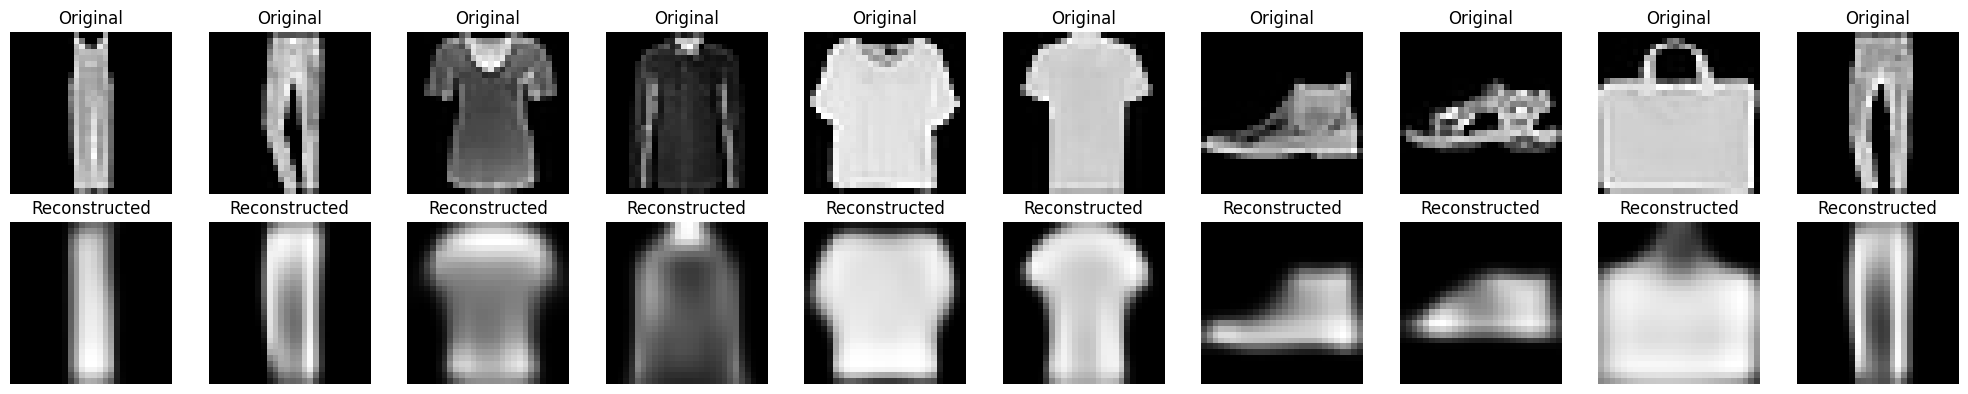

MSE for the selected 10 images: 0.016309


In [11]:
X_train, X_val, X_test, y_train, y_val, y_test = load_and_preprocess_FashionMNIST(config["train_folder_FashionMNIST"])
# print(f"y_train: {y_train[0]}")
# sys.exit()
train_dataset = FashionMNIST(X_train, y_train)
val_dataset = FashionMNIST(X_val, y_val)
test_dataset = FashionMNIST(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=config["cnn_autoencoder"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config["cnn_autoencoder"]["batch_size"], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config["cnn_autoencoder"]["batch_size"], shuffle=False)

cnn_autoencoder = CNNAutoEncoder(
    lr=config["cnn_autoencoder"]["lr"],
    input_channels=config["cnn_autoencoder"]["input_channels"],
    input_size=config["cnn_autoencoder"]["input_size"],
    latent_dim=config["cnn_autoencoder"]["latent_dim"],
    optimizer=config["cnn_autoencoder"]["optimizer"],
    n_cnn_layers=config["cnn_autoencoder"]["n_cnn_layers"],
    kernel_size=config["cnn_autoencoder"]["kernel_size"],
    padding=config["cnn_autoencoder"]["padding"],
    dropout=config["cnn_autoencoder"]["dropout"]
)

train_CNN_AutoEncoder(cnn_autoencoder, config["cnn_autoencoder"]["num_epochs"], train_dataloader=train_dataloader, val_dataloader=val_dataloader, device=device)
results = evaluate_CNN_AutoEncoder(cnn_autoencoder, test_dataloader=test_dataloader, device=device)
print(results)

original_images = plot_and_visualize(cnn_autoencoder, test_dataloader=test_dataloader, device=device, num_images=10)



In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
from torch.utils.data import DataLoader
import seaborn as sns

def visualize_latent_space(model, dataloader, device, n_samples=1000):
    """
    Visualize the latent space representations using PCA for both 2D and 3D plots.
    
    Args:
        model: Trained autoencoder model
        dataloader: DataLoader containing the dataset
        device: Device to run the model on
        n_samples: Number of samples to visualize
    """
    # Set model to evaluation mode
    model.eval()
    
    # Lists to store encodings and labels
    encodings = []
    labels = []
    
    # Collect encodings and labels
    with torch.no_grad():
        for data, label in dataloader:
            if len(encodings) * data.shape[0] >= n_samples:
                break
                
            data = data.to(device)
            # Get encoded representations
            encoding = model.encode(data)
            
            encodings.append(encoding.cpu().numpy())
            # Convert one-hot encoded labels back to class indices
            batch_labels = torch.argmax(label, dim=1).numpy()
            labels.append(batch_labels)
    
    # Concatenate all batches
    encodings = np.concatenate(encodings, axis=0)[:n_samples]
    labels = np.concatenate(labels, axis=0)[:n_samples]
    
    # Apply PCA for 2D and 3D visualization
    pca_2d = PCA(n_components=2)
    pca_3d = PCA(n_components=3)
    
    encodings_2d = pca_2d.fit_transform(encodings)
    encodings_3d = pca_3d.fit_transform(encodings)
    
    # Set up the figure with two subplots
    fig = plt.figure(figsize=(20, 8))
    
    # 2D Plot
    ax1 = fig.add_subplot(121)
    scatter_2d = ax1.scatter(encodings_2d[:, 0], encodings_2d[:, 1], 
                           c=labels, cmap='tab10', alpha=0.6)
    ax1.set_title('2D PCA of Latent Space')
    ax1.set_xlabel(f'First Principal Component\nExplained Variance: {pca_2d.explained_variance_ratio_[0]:.3f}')
    ax1.set_ylabel(f'Second Principal Component\nExplained Variance: {pca_2d.explained_variance_ratio_[1]:.3f}')
    plt.colorbar(scatter_2d, ax=ax1, label='Class')
    
    # 3D Plot
    ax2 = fig.add_subplot(122, projection='3d')
    scatter_3d = ax2.scatter(encodings_3d[:, 0], encodings_3d[:, 1], encodings_3d[:, 2],
                           c=labels, cmap='tab10', alpha=0.6)
    ax2.set_title('3D PCA of Latent Space')
    ax2.set_xlabel(f'PC1\nVar: {pca_3d.explained_variance_ratio_[0]:.3f}')
    ax2.set_ylabel(f'PC2\nVar: {pca_3d.explained_variance_ratio_[1]:.3f}')
    ax2.set_zlabel(f'PC3\nVar: {pca_3d.explained_variance_ratio_[2]:.3f}')
    plt.colorbar(scatter_3d, ax=ax2, label='Class')
    
    # Calculate and print the total explained variance
    total_var_2d = pca_2d.explained_variance_ratio_.sum()
    total_var_3d = pca_3d.explained_variance_ratio_.sum()
    print(f"Total explained variance (2D): {total_var_2d:.3f}")
    print(f"Total explained variance (3D): {total_var_3d:.3f}")
    
    # Analyze class separation
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=6)  # 5 neighbors + self
    nn.fit(encodings_2d)
    distances, indices = nn.kneighbors(encodings_2d)
    
    # Calculate percentage of same-class neighbors
    same_class = 0
    total_neighbors = 0
    for i in range(len(labels)):
        same_class += sum(labels[i] == labels[indices[i][1:]])  # exclude self
        total_neighbors += 5  # number of neighbors
    
    clustering_quality = same_class / total_neighbors
    print(f"Clustering quality (fraction of same-class neighbors): {clustering_quality:.3f}")
    
    plt.tight_layout()
    plt.show()
    plt.savefig("latent_space_visualization.png")
    plt.close()
    
    return total_var_2d, total_var_3d, clustering_quality


/tmp/ipykernel_43144/4167049181.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(get_one_hot_encoding([self.y[idx]], 10))


Total explained variance (2D): 0.449
Total explained variance (3D): 0.536
Clustering quality (fraction of same-class neighbors): 0.439


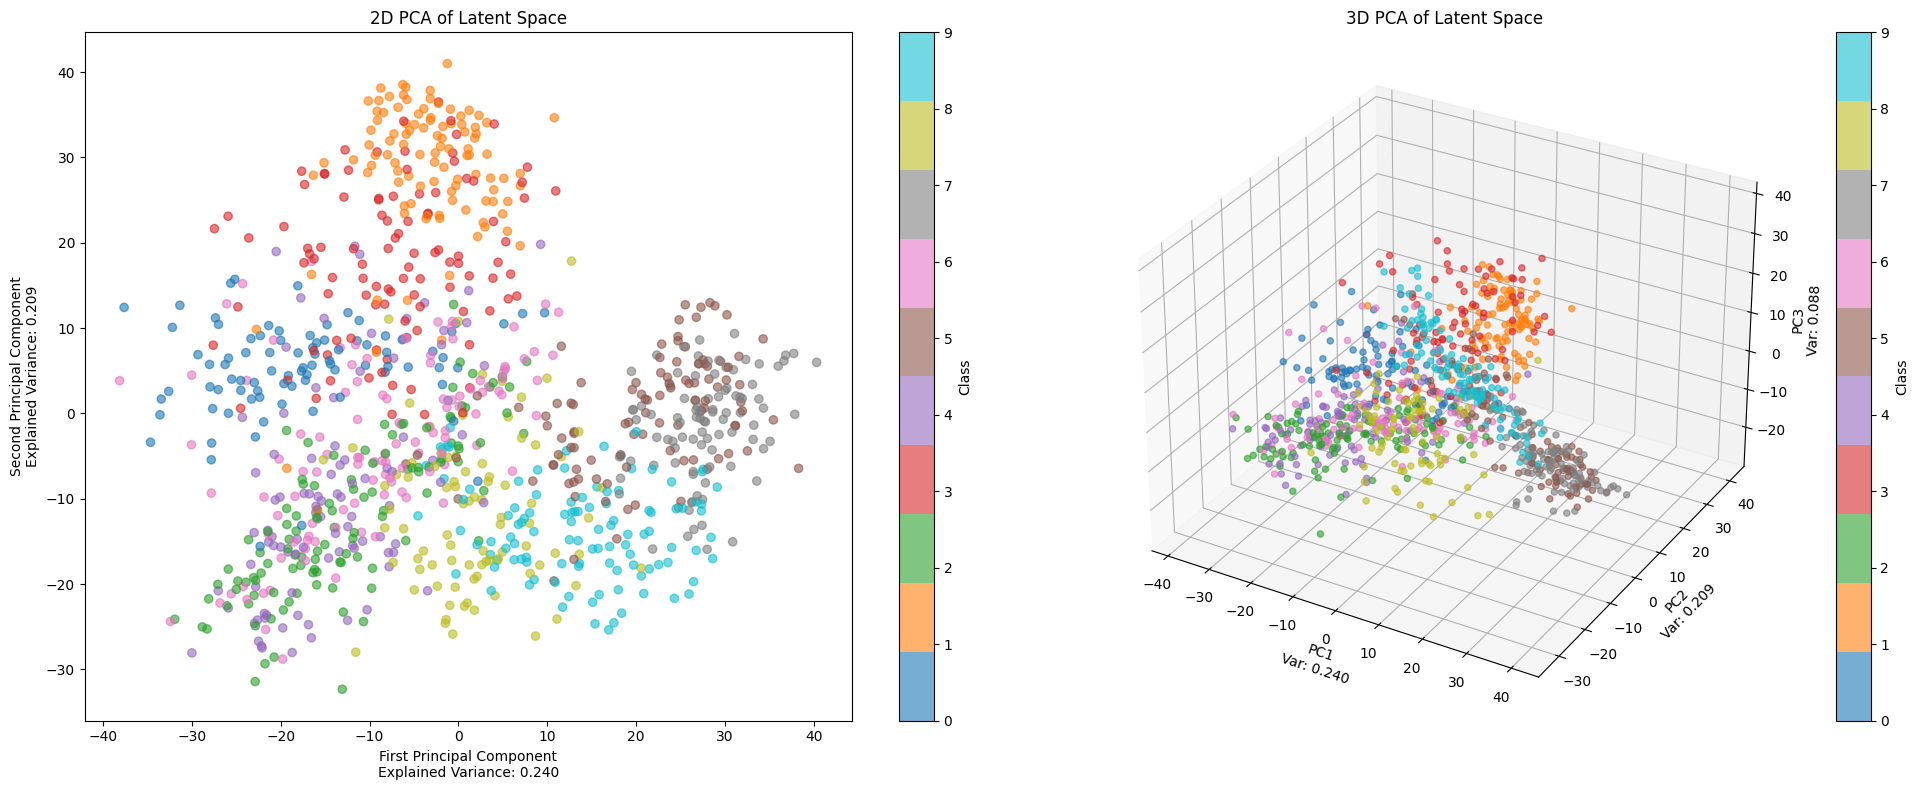

In [13]:
total_var_2d, total_var_3d, clustering_quality = visualize_latent_space(
    model=cnn_autoencoder,
    dataloader=test_dataloader,
    device=device,
    n_samples=1000
)

Based on the visualizations and metrics provided, here are some key observations about the latent space representations:

1. Explained Variance:
- The 2D PCA captures about 44.9% of the total variance in the data
- Adding a third dimension increases this to 53.6% (only ~9% additional information)
- The first principal component explains 24% of the variance, while the second explains about 20.9%
- This relatively low total explained variance suggests that the 128-dimensional latent space contains complex, high-dimensional features that cannot be easily reduced to 2D/3D

2. Clustering Structure:
- There is some visible clustering of classes, but with significant overlap
- The clustering quality metric of 0.439 indicates that only about 44% of nearest neighbors belong to the same class
- Some classes (like the brown/gray cluster on the right) appear more distinctly separated than others
- The center of the plot shows considerable mixing of different classes, suggesting some fashion items share similar latent representations

3. Spatial Distribution:
- The data points form a roughly circular/spherical distribution in both 2D and 3D plots
- There's no strong linear separation between classes, suggesting complex decision boundaries
- Some classes appear to form elongated clusters rather than tight spherical clusters
- The spread of points suggests the autoencoder has learned a continuous latent space rather than discrete clusters

4. Class Relationships:
- Similar fashion items (e.g., different types of footwear or clothing) seem to be positioned closer together
- The orange/red classes (likely similar clothing categories) are clustered together in the upper portion of the 2D plot
- The blue/cyan classes form overlapping clusters in the lower right region
- This suggests the autoencoder has learned meaningful feature representations that reflect item similarities

5. Areas for Improvement:
- The relatively low clustering quality suggests room for improvement in class separation
- Adding class information during training (semi-supervised approach) might help create more distinct clusters
- Increasing the latent space dimensionality might allow for better class separation
- Alternative dimension reduction techniques (like t-SNE or UMAP) might reveal different clustering patterns

### 4.2.4 Hyperparameter Tuning (10 Marks)

In [ ]:
def tune_hyperparameters_normal():
    l_rate_list = [1e-3, 1e-4]
    kernel_size_list = [3, 5]
    filter_sizes_list = [[16, 32], [32, 64]]
    results_list = []

    sweep_config = {
        "method": "grid",
        "name": f"CNN_AEC_Normal",
        "metric": {
            "goal": "maximize",
            "name": "test/accuracy"
        },
        "parameters": {
            "l_rate": {
                "values": l_rate_list
            },
            "kernel_size": {
                "values": kernel_size_list
            },
            "filter_size": {
                "values": filter_sizes_list
            }
        }
    }

    sweep_id = wandb.sweep(
        sweep_config,
        project="SMAI-A4"
    )

    def tune_model():
        wandb.init(
            project="SMAI-A4"
        )
        sleep_config = wandb.config
        l_rate = sleep_config.l_rate
        kernel_size = sleep_config.kernel_size
        filter_size = sleep_config.filter_size

        model = CNNAutoEncoder(
            lr=l_rate,
            input_channels=config["cnn_autoencoder"]["input_channels"],
            input_size=config["cnn_autoencoder"]["input_size"],
            latent_dim=config["cnn_autoencoder"]["latent_dim"],
            optimizer=config["cnn_autoencoder"]["optimizer"],
            kernel_size=kernel_size,
            padding=config["cnn_autoencoder"]["padding"],
            dropout=config["cnn_autoencoder"]["dropout"],
            num_classes=config["cnn_autoencoder"]["num_classes"],
            filters_per_layer=filter_size
        ).to(device)

        train_CNN_AutoEncoder(
            model,
            config["cnn_autoencoder"]["num_epochs"],
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            device=device,
            alpha=config["cnn_autoencoder"]["alpha"]
        )
        results = evaluate_CNN_AutoEncoder(
            model=model,
            test_dataloader=test_dataloader,
            device=device,
            alpha=config["cnn_autoencoder"]["alpha"]
        )

        results_list.append(results)

        wandb.log({
            "lr": l_rate,
            "kernel_size": kernel_size,
            "filters": filter_size,
            "test/total_loss": results["total_loss"],
            "test/reconstruction_loss": results["reconstruction_loss"],
            "test/classification_loss": results["classification_loss"],
            "test/accuracy": results["accuracy"]
        })

    wandb.agent(sweep_id=sweep_id, function=tune_model)

    df = pd.DataFrame(results_list)
    df = df.sort_values(by="test/accuracy", ascending=False)
    df = df.reset_index(drop=True)
    print(f"HT: CNN AutoEncoder Classification")
    print(df.to_string(index=False))
    best_params = df.iloc[0].to_string(index=False)
    print(f"\bBest Model Parameters")
    print(best_params)
    wandb.finish()

def tune_hyperparameters_constrained():
    filter_sizes_list = [[16], [16, 32], [16, 32, 64]]
    results_list = []

    sweep_config = {
        "method": "grid",
        "name": f"CNN_AEC_constrained",
        "metric": {
            "goal": "maximize",
            "name": "test/accuracy"
        },
        "parameters": {
            "filter_size": {
                "values": filter_sizes_list
            }
        }
    }

    sweep_id = wandb.sweep(
        sweep_config,
        project="SMAI-A4"
    )

    def tune_model():
        wandb.init(
            project="SMAI-A4"
        )
        sleep_config = wandb.config
        filter_size = sleep_config.filter_size

        model = CNNAutoEncoder(
            lr=config["cnn_autoencoder"]["lr"],
            input_channels=config["cnn_autoencoder"]["input_channels"],
            input_size=config["cnn_autoencoder"]["input_size"],
            latent_dim=config["cnn_autoencoder"]["latent_dim"],
            optimizer=config["cnn_autoencoder"]["optimizer"],
            kernel_size=config["cnn_autoencoder"]["kernel_size"],
            padding=config["cnn_autoencoder"]["padding"],
            dropout=config["cnn_autoencoder"]["dropout"],
            num_classes=config["cnn_autoencoder"]["num_classes"],
            filters_per_layer=filter_size
        ).to(device)

        train_CNN_AutoEncoder(
            model,
            config["cnn_autoencoder"]["num_epochs"],
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            device=device,
            alpha=config["cnn_autoencoder"]["alpha"]
        )
        results = evaluate_CNN_AutoEncoder(
            model=model,
            test_dataloader=test_dataloader,
            device=device,
            alpha=config["cnn_autoencoder"]["alpha"]
        )

        results_list.append(results)

        wandb.log({
            "filters": filter_size,
            "test/total_loss": results["total_loss"],
            "test/reconstruction_loss": results["reconstruction_loss"],
            "test/classification_loss": results["classification_loss"],
            "test/accuracy": results["accuracy"]
        })

    wandb.agent(sweep_id=sweep_id, function=tune_model)

    df = pd.DataFrame(results_list)
    df = df.sort_values(by="test/accuracy", ascending=False)
    df = df.reset_index(drop=True)
    print(f"HT: CNN AutoEncoder Classification")
    print(df.to_string(index=False))
    best_params = df.iloc[0].to_string(index=False)
    print(f"\bBest Model Parameters")
    print(best_params)
    wandb.finish()

# HYPERPARAMETER TUNING
tune_hyperparameters_normal()
tune_hyperparameters_constrained()

Normal Hyperparameter Tuning:

"Name","slc.dropout","filters","Runtime","filter_size","kernel_size","l_rate","test/accuracy","test/classification_loss","test/reconstruction_loss","test/total_loss"
"valiant-sweep-5","","[32,64]","45","[32,64]","3","0.001","89.775","0.28312232448657354","0.01772564020504554","0.09734464872876802"
"cerulean-sweep-1","","[16,32]","45","[16,32]","3","0.001","89.51666666666667","0.2997930064102014","0.0177193810865283","0.1023414723277092"
"driven-sweep-7","","[32,64]","43","[32,64]","5","0.001","89.50833333333334","0.2887050380706787","0.03837204977373282","0.11347194948792458"
"prime-sweep-6","","[32,64]","38","[32,64]","3","0.0001","89.31666666666666","0.29654132265845934","0.019331442346175513","0.10249440948168435"
"ethereal-sweep-3","","[16,32]","46","[16,32]","5","0.001","88.85","0.31799269118905066","0.038704092115163805","0.12249067503213884"
"devoted-sweep-8","","[32,64]","45","[32,64]","5","0.0001","88.4","0.32600273525714873","0.039026354307929674","0.12511927250027657"
"silver-sweep-2","","[16,32]","44","[16,32]","3","0.0001","88.23333333333333","0.3289849919080734","0.02170705551902453","0.11389044029513996"
"pretty-sweep-4","","[16,32]","45","[16,32]","5","0.0001","86.975","0.37522031778097154","0.04097164668639501","0.14124625237782795"


Best Model: 
"valiant-sweep-5","","[32,64]","45","[32,64]","3","0.001","89.775","0.28312232448657354","0.01772564020504554","0.09734464872876802"

Constrained Hyperparameter Tuning:
"Name","filter_size","test/accuracy","test/classification_loss","test/reconstruction_loss","test/total_loss"
"celestial-sweep-2","[16,32]","89.65833333333333","0.2840610917607943","0.017709560049076874","0.09761502294739088"
"lemon-sweep-3","[16,32,64]","88.60833333333333","0.3080664453903834","0.02397302109499773","0.10920105134447416"
"sweet-sweep-1","[16]","87.86666666666666","0.3178211927165588","0.015983638636767866","0.1065349086423715"

Best Model:
"celestial-sweep-2","[16,32]","89.65833333333333","0.2840610917607943","0.017709560049076874","0.09761502294739088"

`Observations`:

Based on the hyperparameter tuning results, few observations:

1. **Filter and Kernel Size Impact**:
   - Models with a filter configuration of `[32, 64]` and kernel size of 3 showed better accuracy, lower classification loss, and reconstruction loss than models with larger kernel sizes (e.g., kernel size of 5). This suggests that smaller kernel sizes may be more effective in capturing the local features in the Fashion MNIST dataset.
   - The constrained tuning with filter size `[16, 32]` yielded a strong performance for the "celestial-sweep-2" model, indicating that a simpler model can still achieve comparable accuracy.

2. **Learning Rate Sensitivity**:
   - Learning rate `0.001` performed well in most configurations, suggesting it is a reasonable default for this model. Lower learning rates (like `0.0001`) resulted in slightly lower accuracy and higher total loss, likely due to slower convergence.

3. **Performance Variability Across Depth**:
   - Deeper architectures (such as configurations with additional filter sizes like `[16, 32, 64]`) did not necessarily improve accuracy, suggesting that adding layers may increase complexity without a significant gain in performance for this dataset.

4. **Reconstruction vs. Classification Loss**:
   - Lower reconstruction loss values correlate with higher classification accuracy, indicating that the model is learning to reconstruct well enough to capture distinguishing features of clothing classes effectively.

## 4.3 MLP AutoEncoder (15 Marks)

In [ ]:
# MLP Classifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
import pickle

class MLP_classifier:
    def __init__(
            self, 
            input_dim: int, 
            output_dim: int, 
            n_hidden_layers: int = 3, 
            hidden_dim: int = 32, 
            lr: float = 1e-4, 
            act_type: str="sigmoid", 
            optimizer_type: str="mini", 
            batch_size: int=8, 
            max_iter: int=10000, 
            do_gradient_check:bool = False,
            do_multi_label: bool = False,
            objective: str = "classification"
        ):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.act_type = act_type
        self.optimizer_type = optimizer_type
        self.n_hidden_layers = n_hidden_layers
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.set_activation_function() # Initialize according to provided argument
        self.set_optimizer(optimizer_type)
        self.weights = self.initialize_weights() # Initialize the weights upon class initialization itself
        self.do_gradient_check = do_gradient_check
        self.do_multi_label = do_multi_label
        self.objective = objective
        
    def get_lr(self) -> float:
        return self.lr

    def set_lr(self, lr: float) -> None:
        self.lr = lr

    def get_max_iter(self) -> int:
        return self.max_iter
    
    def set_max_iter(self, max_iter: int) -> None:
        self.max_iter = max_iter
    
    def get_act_type(self) -> str:
        return self.act_type
    
    def set_act_type(self, act_type: str) -> None:
        self.act_type = act_type
        self.activation_function()

    def get_optimizer(self) -> str:
        return self.optimizer_type
    
    def set_optimizer(self, optimizer_type: str) -> None:
        if optimizer_type == "batch":
            self.train_function = self.train_batch
        elif optimizer_type == "mini":
            self.train_function = self.train_mini_batch
        elif optimizer_type == "sgd":
            self.train_function = self.train_sgd
        else:
            raise(ValueError("Invalid optimizer type"))
        

    def get_n_hidden_layers(self) -> int:
        return self.n_hidden_layers
    
    def set_n_hidden_layers(self, n_hidden_layers: int) -> None:
        self.n_hidden_layers = n_hidden_layers

    def get_hidden_dim(self) -> int:
        return self.hidden_dim 
    
    def set_hidden_dim(self, hidden_dim: int) -> None:
        self.hidden_dim = hidden_dim

    def linear(self, z):
        return z
    
    def linear_prime(self, z):
        return np.ones_like(z.shape[1])

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_prime(self, z):
        return (self.sigmoid(z)) * (1 - (self.sigmoid(z)))
    
    def tanh(self, z):
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

    def tanh_prime(self, z):
        return (1 - np.square(self.tanh(z)))

    def relu(self, z):
        return np.maximum(0, z)
    
    def relu_prime(self, z) -> float:
        return np.where(z > 0, 1.0, 0.0)
    
    def leakyrelu(self, z, neg_slope: float=0.01):
        return np.maximum(neg_slope * z, z)
    
    def leakyrelu_prime(self, z, neg_slope: float=0.01) -> float:
        return np.where(z > 0, 1.0, neg_slope)
    
    def set_activation_function(self):
        if self.act_type == "sigmoid":
            self.activation_function = self.sigmoid
            self.activation_function_prime = self.sigmoid_prime
        elif self.act_type == "tanh":
            self.activation_function = self.tanh
            self.activation_function_prime = self.tanh_prime
        elif self.act_type == "relu":
            self.activation_function = self.relu
            self.activation_function_prime = self.relu_prime
        elif self.act_type == "leakyrelu":
            self.activation_function = self.leakyrelu
            self.activation_function_prime = self.leakyrelu_prime
        elif self.act_type == "linear":
            self.activation_function = self.linear
            self.activation_function_prime = self.linear_prime
        else:
            raise(ValueError("Invalid activation function"))
        
    def initialize_weights(self):
        weights = []
        layer_sizes = [self.input_dim] + [self.hidden_dim] * self.n_hidden_layers + [self.output_dim]
        for i in range(1, len(layer_sizes)):
            weights.append(np.random.randn(layer_sizes[i - 1], layer_sizes[i]))
        return weights
        
    def softmax(self, z):
        e_z = np.exp(z - np.max(z))
        return e_z / e_z.sum(axis = 1, keepdims=True)
        
    def forward(self, X: np.ndarray):
        # print(f"Forward input shape: {X.shape}")
        activated = [X]
        pre_activated = []
        for layer in range(0, self.n_hidden_layers):
            # print(f"acivated[layer]_shape: {activated[layer].shape}")
            # print(f"self.weights[layer]_shape: {self.weights[layer].shape}")
            z = np.dot(activated[layer], self.weights[layer]) # Z' = A * W
            a = self.activation_function(z) # A' = activation_function(Z')
            pre_activated.append(z)
            activated.append(a)

        z = np.dot(activated[self.n_hidden_layers], self.weights[self.n_hidden_layers])
        pre_activated.append(z)
        if self.objective == "classification":
            self.y_ht = self.softmax(pre_activated[-1]) # Classification use the softmaxed output (since we deal with probabilities)
        else:
            self.y_ht = pre_activated[-1] # Regression: directly use raw output
        activated.append(self.y_ht)
        self.activations = activated # A's
        self.weighted_sums = pre_activated # Z's
        # print(f"Forward output shape: {self.y_ht.shape}")
        return self.y_ht
        
    # Classification optimizes cross entropy loss
    # def cost_function_classification(self, X: np.ndarray, y: np.ndarray):
    #     self.y_ht = self.forward(X)
    #     loss = (-1) * np.sum((y * np.log(self.y_ht)) / len(X)) # Usign log for stability (avoids underflow)
    #     return loss
    
    # # Cross Entropy
    # def cost_function_classification(self, X: np.ndarray, y: np.ndarray):
    #     epsilon = 1e-15  # To avoid log(0)
    #     self.y_ht = self.forward(X)  # self.y_ht should be the predicted probabilities
    #     # Compute cross-entropy loss
    #     loss = - np.mean(y * np.log(self.y_ht + epsilon) + (1 - y) * np.log(1 - self.y_ht + epsilon))
    #     return loss
    
    # KL-Divergence Loss
    def cost_function_classification(self, X: np.ndarray, y: np.ndarray):
        epsilon = 1e-15  # To avoid log(0)
        self.y_ht = self.forward(X)  # self.y_ht should be the predicted probabilities
        # Compute KL-Divergence loss
        loss = np.sum(y * np.log((y + epsilon) / (self.y_ht + epsilon))) / len(X)
        return loss

    # Regression optimizes Mean Square Error
    def cost_function_regression(self, X: np.ndarray, y: np.ndarray):
        self.y_ht = self.forward(X)
        loss = np.square(y - self.y_ht).mean() # better numerical stability
        return loss
    
    def backward(self, X: np.ndarray, y: np.ndarray):
        m = X.shape[0]
        # print(f"y_shape: {y.shape}")
        # print(f"self.activations[-1]_shape: {self.activations[-1].shape}")
        
        # Initialize gradients list
        gradients = [np.zeros_like(w) for w in self.weights]
        
        # Output layer error
        if self.objective == "classification":
            delta = self.activations[-1] - y  # For softmax with cross-entropy, this is the gradient
        elif self.objective == "regression":
            delta = 2 * (self.activations[-1] - y) / m
        
        # Calculate gradient for the last layer
        gradients[-1] = np.dot(self.activations[-2].T, delta) / m
        
        # Backpropagate through hidden layers
        for layer in reversed(range(self.n_hidden_layers)):
            # Propagate error
            # print(f"delta_shape: {delta.shape}")
            # print(f"self.weights[layer+1].T: {self.weights[layer+1].T.shape}")
            # print(f"self.weighted_sums[layer]: {self.weighted_sums[layer].shape}")
            delta = np.dot(delta, self.weights[layer+1].T) * self.activation_function_prime(self.weighted_sums[layer])
            
            # Calculate gradient
            gradients[layer] = np.dot(self.activations[layer].T, delta) / m
        
        return gradients
    
    def compute_gradients(self, X: np.ndarray, y: np.ndarray):
        # Forward Propagation
        self.forward(X) # (n_samples, output_dim)
        # Backward Propagation
        gradients = self.backward(X, y)
        return np.concatenate([grad.ravel() for grad in gradients])

    # Update Steps
    def get_params(self):
        return np.concatenate([w.ravel() for w in self.weights])
    
    def set_params(self, params):
        start = 0
        for i in range(len(self.weights)):
            end = start + self.weights[i].size
            self.weights[i] = params[start:end].reshape(self.weights[i].shape)
            start = end
    
    def update(self, gradients):
        # print(f"Shape of gradients (input to Update): {gradients.shape}")
        params = self.get_params()
        updated_params = params - self.lr * gradients
        self.set_params(updated_params)

    # Note: all changes needed to hyperparameters must be done manually before calling train_batch
    def train_batch(self, X: np.ndarray, y: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, wandb_log = False, max_iterations=None, batch_size:int = None):
        if self.do_gradient_check:
            self.run_gradient_check(X, y)
        
        self.losses = []
        if self.objective == "classification":
            loss = self.cost_function_classification(X, y)
        elif self.objective == "regression":
            loss = self.cost_function_regression(X, y)
        print(f"Initial Loss:\t{loss}")
        if max_iterations is not None:
            self.set_max_iter(max_iterations) # Set max_iter to max_iterations

        epochs_trained = 0
        for epoch in range(self.max_iter):
            if ((epoch >= 3) and (self.losses[-2] - self.losses[-1]) <= 1e-5):
                print(f"Early Stopping at iteration: {epoch}")
                break
            
            gradients = self.compute_gradients(X, y)
            # print(f"gradients shape: {gradients.shape}")
            if self.objective == "classification":
                loss = self.cost_function_classification(X, y)
            elif self.objective == "regression":
                loss = self.cost_function_regression(X, y)
            self.losses.append(loss)
            self.update(gradients)

            # test loss
            if self.objective == "classification":
                loss_val = self.cost_function_classification(X_val, y_val)
            elif self.objective == "regression":
                loss_val = self.cost_function_regression(X_val, y_val)
            if epoch % 100 == 0:
                print(f"Epoch:\t{epoch}\ttrain/loss:\t{loss}\tvalidation/loss:\t{loss_val}")
            if self.objective == "classification":
                a_s, p_s, r_s, f_s = self.evaluate_validation(X_val, y_val)
                if wandb_log == True:
                    wandb.log({
                        "epoch": epoch, 
                        "train/loss": loss,
                        "validation/loss": loss_val,
                        "validation/accuracy": a_s,
                        "validation/precision": p_s,
                        "validation/recall": r_s,
                        "validation/f1_score": f_s
                    })
                epochs_trained += 1
            elif self.objective == "regression":
                mse, rmse, r_squared = self.evaluate_validation(X_val, y_val)
                if wandb_log == True:
                    wandb.log({
                        "epoch": epoch,
                        "train/loss": loss,
                        "validation/loss": loss_val,
                        "validation/mse": mse,
                        "validation/rmse": rmse,
                        "validation/r_squared": r_squared
                    })
                epochs_trained += 1

        if self.objective == "classification":
            loss = self.cost_function_classification(X, y)
            loss_val = self.cost_function_classification(X_val, y_val)
        elif self.objective == "regression":
            loss = self.cost_function_regression(X, y)
            loss_val = self.cost_function_regression(X_val, y_val)
        print(f"Batch training successful")
        print(f"Total Epochs: {epochs_trained}")
        print(f"Final Train Loss: {loss}")
        print(f"Final Validation Loss: {loss_val}")
        if self.objective == "classification":
            a_s, p_s, r_s, f_s = self.evaluate_validation(X_val, y_val)
            if wandb_log == True:
                wandb.log({
                    "epoch": epoch, 
                    "train/loss": loss,
                    "validation/loss": loss_val,
                    "validation/accuracy": a_s,
                    "validation/precision": p_s,
                    "validation/recall": r_s,
                    "validation/f1_score": f_s
                })
        elif self.objective == "regression":
            mse, rmse, r_squared = self.evaluate_validation(X_val, y_val)
            if wandb_log == True:
                wandb.log({
                    "epoch": epoch,
                    "train/loss": loss,
                    "validation/loss": loss_val,
                    "validation/mse": mse,
                    "validation/rmse": rmse,
                    "validation/r_squared": r_squared
                })

        return loss
    
    def train_mini_batch(self, X: np.ndarray, y: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, wandb_log=False, max_iterations=None, batch_size: int=32):
        if self.do_gradient_check:
            self.run_gradient_check(X, y)
        self.losses = []
        if self.objective == "classification":
            loss = self.cost_function_classification(X, y)
        elif self.objective == "regression":
            loss = self.cost_function_regression(X, y)
        print(f"Initial Loss:\t{loss}")
        if max_iterations is not None:
            self.set_max_iter(max_iterations)

        epochs_trained = 0
        for epoch in range(self.max_iter):
            # if ((epoch >= 3) and (self.losses[-3] - self.losses[-1]) <= 1e-5):
            #     print(f"Early Stopping at iteration: {epoch}")
            #     break
            
            # make batches from 1 sized batches
            indices = np.arange(len(X))
            # print(f"indices: {indices}")
            np.random.shuffle(indices)
            for i in range(0, len(X), batch_size):
                batch_indices = indices[i: i + batch_size]
                gradients = self.compute_gradients(X[batch_indices], y[batch_indices])
                self.update(gradients)
            if self.objective == "classification":
                loss = self.cost_function_classification(X, y)
            elif self.objective == "regression":
                loss = self.cost_function_regression(X, y)
            self.losses.append(loss)

            # Validation loss
            if self.objective == "classification":
                loss_val = self.cost_function_classification(X_val, y_val)
            elif self.objective == "regression":
                loss_val = self.cost_function_regression(X_val, y_val)
            if epoch % 1 == 0:
                print(f"Epoch:\t{epoch}\ttrain/loss:\t{loss}\tvalidation/loss:\t{loss_val}")
            if self.objective == "classification":
                a_s, p_s, r_s, f_s = self.evaluate_validation(X_val, y_val)
                if wandb_log == True:
                    wandb.log({
                        "epoch": epoch, 
                        "train/loss": loss,
                        "validation/loss": loss_val,
                        "validation/accuracy": a_s,
                        "validation/precision": p_s,
                        "validation/recall": r_s,
                        "validation/f1_score": f_s
                    })
                epochs_trained += 1
            elif self.objective == "regression":
                mse, rmse, r_squared = self.evaluate_validation(X_val, y_val)
                if wandb_log == True:
                    wandb.log({
                        "epoch": epoch,
                        "train/loss": loss,
                        "validation/loss": loss_val,
                        "validation/mse": mse,
                        "validation/rmse": rmse,
                        "validation/r_squared": r_squared
                    })
                epochs_trained += 1

        if self.objective == "classification":
            loss = self.cost_function_classification(X, y)
            loss_val = self.cost_function_classification(X_val, y_val)
        elif self.objective == "regression":
            loss = self.cost_function_regression(X, y)
            loss_val = self.cost_function_regression(X_val, y_val)
        print(f"Mini-Batch training successful")
        print(f"Total Epochs: {epochs_trained}")
        print(f"Final Train Loss: {loss}")
        print(f"Final Validation Loss: {loss_val}")
        if self.objective == "classification":
            a_s, p_s, r_s, f_s = self.evaluate_validation(X_val, y_val)
            if wandb_log == True:
                wandb.log({
                    "epoch": epoch, 
                    "train/loss": loss,
                    "validation/loss": loss_val,
                    "validation/accuracy": a_s,
                    "validation/precision": p_s,
                    "validation/recall": r_s,
                    "validation/f1_score": f_s
                })
        elif self.objective == "regression":
            mse, rmse, r_squared = self.evaluate_validation(X_val, y_val)
            if wandb_log == True:
                wandb.log({
                    "epoch": epoch,
                    "train/loss": loss,
                    "validation/loss": loss_val,
                    "validation/mse": mse,
                    "validation/rmse": rmse,
                    "validation/r_squared": r_squared
                })

        return loss
    
    def train_sgd(self, X: np.ndarray, y: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, wandb_log=False, max_iterations=None, batch_size: int=None):
        batch_size = 1
        EARLY_THRESHOLD = 1e-5

        if self.do_gradient_check:
            self.run_gradient_check(X, y)
        self.losses = []
        if self.objective == "classification":
            loss = self.cost_function_classification(X, y)
        elif self.objective == "regression":
            loss = self.cost_function_regression(X, y)
        print(f"Initial Loss:\t{loss}")
        if max_iterations is not None:
            self.set_max_iter(max_iterations)

        epochs_trained = 0
        val_loss_list = []

        for epoch in range(self.max_iter):
            # make batches from 1 sized batches
            indices = np.arange(len(X))
            # print(f"indices: {indices}")
            np.random.shuffle(indices)
            for i in range(0, len(X), batch_size):
                batch_indices = indices[i: i + batch_size]
                gradients = self.compute_gradients(X[batch_indices], y[batch_indices])
                self.update(gradients)

            if self.objective == "classification":
                loss = self.cost_function_classification(X, y)
            elif self.objective == "regression":
                loss = self.cost_function_regression(X, y)
            self.losses.append(loss)

            # Validation loss
            if self.objective == "classification":
                loss_val = self.cost_function_classification(X_val, y_val)
            elif self.objective == "regression":
                loss_val = self.cost_function_regression(X_val, y_val)
            val_loss_list.append(loss_val)

            if epoch % 100 == 0:
                print(f"Epoch:\t{epoch}\ttrain/loss:\t{loss}\tvalidation/loss:\t{loss_val}")
            if self.objective == "classification":
                a_s, p_s, r_s, f_s = self.evaluate_validation(X_val, y_val)
                if wandb_log == True:
                    wandb.log({
                        "epoch": epoch, 
                        "train/loss": loss,
                        "validation/loss": loss_val,
                        "validation/accuracy": a_s,
                        "validation/precision": p_s,
                        "validation/recall": r_s,
                        "validation/f1_score": f_s
                    })
                epochs_trained += 1
            elif self.objective == "regression":
                mse, rmse, r_squared = self.evaluate_validation(X_val, y_val)
                if wandb_log == True:
                    wandb.log({
                        "epoch": epoch,
                        "train/loss": loss,
                        "validation/loss": loss_val,
                        "validation/mse": mse,
                        "validation/rmse": rmse,
                        "validation/r_squared": r_squared
                    })
                epochs_trained += 1
            # if epoch >= 2:
            #     if (self.losses[-2] - self.losses[-1]) <= EARLY_THRESHOLD:
            #         print(f"Early Stopping at epoch: {epoch}")
            #         break

        if self.objective == "classification":
            loss = self.cost_function_classification(X, y)
            loss_val = self.cost_function_classification(X_val, y_val)
        elif self.objective == "regression":
            loss = self.cost_function_regression(X, y)
            loss_val = self.cost_function_regression(X_val, y_val)
        print(f"SGD training successful")
        print(f"Total Epochs: {epochs_trained}")
        print(f"Final Train Loss: {loss}")
        print(f"Final Validation Loss: {loss_val}")
        if self.objective == "classification":
            a_s, p_s, r_s, f_s = self.evaluate_validation(X_val, y_val)
            if wandb_log == True:
                wandb.log({
                    "epoch": epoch, 
                    "train/loss": loss,
                    "validation/loss": loss_val,
                    "validation/accuracy": a_s,
                    "validation/precision": p_s,
                    "validation/recall": r_s,
                    "validation/f1_score": f_s
                })
        elif self.objective == "regression":
            mse, rmse, r_squared = self.evaluate_validation(X_val, y_val)
            if wandb_log == True:
                wandb.log({
                    "epoch": epoch,
                    "train/loss": loss,
                    "validation/loss": loss_val,
                    "validation/mse": mse,
                    "validation/rmse": rmse,
                    "validation/r_squared": r_squared
                })

        return loss

    
    def fit(self, X: np.ndarray, y: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, wandb_log: bool=False, max_iterations: int=None, batch_size: int=None):
        if self.optimizer_type != "mini":
            self.train_function(X, y, X_val, y_val, wandb_log=wandb_log, max_iterations=max_iterations, batch_size=batch_size)
        else:
            self.train_function(X, y, X_val, y_val, wandb_log=wandb_log, max_iterations=max_iterations)
        
    def predict(self, X: np.ndarray):
        if self.do_multi_label == False:
            y_ht = self.forward(X)
            predictions = np.zeros_like(y_ht)
            predictions[np.arange(len(y_ht)), y_ht.argmax(axis=1)] = 1
            return predictions
        else:
            y_ht = self.forward(X)
            binary_predictions = (y_ht > 0.125).astype(int)
            return binary_predictions


    def evaluate_validation(self, X_val_proc: np.ndarray, y_val: np.ndarray):
        if self.objective == "classification":
            y_pred = self.predict(X_val_proc)
            acc_score = accuracy_score(y_val, y_pred)
            prec_score = precision_score(y_val, y_pred, average='macro', zero_division=0)
            rec_score = recall_score(y_val, y_pred, average='macro', zero_division=0)
            f1_s = f1_score(y_val, y_pred, average='micro', zero_division=0)
            return acc_score, prec_score, rec_score, f1_s
        elif self.objective == "regression":
            y_pred = self.forward(X_val_proc)
            mse = np.mean((y_val - y_pred) ** 2)
            rmse = np.sqrt(mse)
            y_mean = np.mean(y_val)
            total_sum_squares = np.sum((y_val - y_mean) ** 2)
            residual_sum_squares = np.sum((y_val - y_pred) ** 2)
            r_squared = 1 - (residual_sum_squares / total_sum_squares)
            return mse, rmse, r_squared

    def evaluate(self, X_val_proc: np.ndarray, X_test_proc: np.ndarray, y_val: np.ndarray, y_test: np.ndarray):
        if self.objective == "classification":
            if self.do_multi_label == False:
                print(f"Performance measure on Single label classification")
                y_pred = self.predict(X_val_proc)
                print(f"-"*90)
                print(f"Evaluation on Validation set")
                print(f"Accuracy:\t{accuracy_score(y_val, y_pred)}")
                print(f"Precision:\t{precision_score(y_val, y_pred, average='macro', zero_division=0)}")
                print(f"Recall:\t{recall_score(y_val, y_pred, average='macro', zero_division=0)}")
                print(f"F1-Score:\t{f1_score(y_val, y_pred, average='micro', zero_division=0)}")
                print(f"-"*90)
                y_pred = self.predict(X_test_proc)
                acc_score = accuracy_score(y_test, y_pred)
                prec_score = precision_score(y_test, y_pred, average='macro', zero_division=0)
                rec_score = recall_score(y_test, y_pred, average='macro', zero_division=0)
                f1_s = f1_score(y_test, y_pred, average='micro', zero_division=0)
                print(f"Evaluation on Test set")
                print(f"Accuracy:\t{acc_score}")
                print(f"Precision:\t{prec_score}")
                print(f"Recall:\t{rec_score}")
                print(f"F1-Score:\t{f1_s}")
                print(f"-"*90)
                return acc_score, prec_score, rec_score, f1_s
            else:
                print(f"Performance measure on Multi label classification")
                y_pred = self.predict(X_val_proc)
                print("True validation:")
                print(y_val)
                print("Binary True Validation")
                binary_y_val = (y_val > 0.125).astype(int)
                print(binary_y_val)
                print("Predicted Validation")
                print(y_pred)
                print(f"-"*90)
                print(f"Evaluation on Validation set")
                print(f"Hamming Loss:\t{hamming_loss(binary_y_val, y_pred)}")
                print(f"Accuracy:\t{accuracy_score(binary_y_val, y_pred)}")
                print(f"Precision:\t{precision_score(binary_y_val, y_pred, average='samples', zero_division=0)}")
                print(f"Recall:\t{recall_score(binary_y_val, y_pred, average='samples', zero_division=0)}")
                print(f"F1-Score:\t{f1_score(binary_y_val, y_pred, average='samples', zero_division=0)}")
                print(f"-"*90)
                y_pred = self.predict(X_test_proc)
                print(f"Evaluation on Test set")
                print(f"Hamming Loss:\t{hamming_loss(y_test, y_pred)}")
                acc_score = accuracy_score(y_test, y_pred)
                print(f"Accuracy:\t{acc_score}")
                prec_score = precision_score(y_test, y_pred, average='samples', zero_division=0)
                print(f"Precision:\t{prec_score}")
                rec_score = recall_score(y_test, y_pred, average='samples', zero_division=0)
                print(f"Recall:\t{rec_score}")
                f1_s = f1_score(y_test, y_pred, average='samples', zero_division=0)
                print(f"F1-Score:\t{f1_s}")
                print(f"-"*90)
                return acc_score, prec_score, rec_score, f1_s
        elif self.objective == "regression":
            print(f"Performance measure on Regression")
            
            # Validation set evaluation
            y_pred_val = self.forward(X_val_proc)
            mse_val = np.mean((y_val - y_pred_val) ** 2)
            rmse_val = np.sqrt(mse_val)
            y_val_mean = np.mean(y_val)
            val_total_sum_squares = np.sum((y_val - y_val_mean) ** 2)
            val_residual_sum_squares = np.sum((y_val - y_pred_val) ** 2)
            r_squared_val = 1 - (val_residual_sum_squares / val_total_sum_squares)
            
            print(f"-"*90)
            print(f"Evaluation on Validation set")
            print(f"Mean Squared Error (MSE):\t{mse_val:.6f}")
            print(f"Root Mean Squared Error (RMSE):\t{rmse_val:.6f}")
            print(f"R-squared (R²):\t{r_squared_val:.6f}")
            print(f"-"*90)
            
            # Test set evaluation
            y_pred_test = self.forward(X_test_proc)
            mse_test = np.mean((y_test - y_pred_test) ** 2)
            rmse_test = np.sqrt(mse_test)
            y_test_mean = np.mean(y_test)
            test_total_sum_squares = np.sum((y_test - y_test_mean) ** 2)
            test_residual_sum_squares = np.sum((y_test - y_pred_test) ** 2)
            r_squared_test = 1 - (test_residual_sum_squares / test_total_sum_squares)
            
            print(f"Evaluation on Test set")
            print(f"Mean Squared Error (MSE):\t{mse_test:.6f}")
            print(f"Root Mean Squared Error (RMSE):\t{rmse_test:.6f}")
            print(f"R-squared (R²):\t{r_squared_test:.6f}")
            print(f"-"*90)
            
            return mse_test, rmse_test, r_squared_test
                

    """
        Gradients checking: https://medium.com/farmart-blog/understanding-backpropagation-and-gradient-checking-6a5c0ba73a68
        https://cs231n.github.io/neural-networks-3/
    """

    def compute_numerical_gradients(self, X: np.ndarray, y: np.ndarray, epsilon: float=1e-7):
        params = self.get_params()
        numerical_gradients = np.zeros_like(params)

        for idx in range(len(params)):
            # create small perturbations
            params_plus = params.copy()
            params_plus[idx] += epsilon
            params_minus = params.copy()
            params_minus[idx] -= epsilon

            # compute cost for both perturbations
            self.set_params(params_plus)
            if self.objective == "classification":
                cost_plus = self.cost_function_classification(X, y)
            elif self.objective == "regression":
                cost_plus = self.cost_function_regression(X, y)

            self.set_params(params_minus)
            if self.objective == "classification":
                cost_minus = self.cost_function_classification(X, y)
            elif self.objective == "regression":
                cost_minus = self.cost_function_regression(X, y)

            # compute numerical gradients
            numerical_gradients[idx] = (cost_plus - cost_minus) / (2 * epsilon)

        # Restore original params
        self.set_params(params)
        return numerical_gradients
    
    def check_gradients(self, X: np.ndarray, y: np.ndarray, epsilon: float=1e-5, tolerance: float=1e-6):
        """
            relative error > 1e-2 usually means the gradient is probably wrong
            1e-2 > relative error > 1e-4 should make you feel uncomfortable
            1e-4 > relative error is usually okay for objectives with kinks. But if there are no kinks (e.g. use of tanh nonlinearities and softmax), then 1e-4 is too high.
            1e-7 and less you should be happy.
        """
        SMALL_EPSILON = 1e-15
        analytical_gradients = self.compute_gradients(X, y)
        # print(f"analytical gradients: {analytical_gradients}")
        numerical_gradients = self.compute_numerical_gradients(X, y, epsilon)
        # print(f"numerical gradients: {numerical_gradients}")

        absolute_diff = np.abs(analytical_gradients - numerical_gradients)
        denominator = np.abs(analytical_gradients) + np.abs(numerical_gradients)
        relative_error = np.where(denominator > 0, (absolute_diff + SMALL_EPSILON) / (denominator + SMALL_EPSILON), 0)
        # relative_error = (absolute_diff + SMALL_EPSILON) / (denominator + SMALL_EPSILON)
        # print(f"relative error: {relative_error}")
        
        max_relative_error = np.max(relative_error)

        is_correct = max_relative_error < tolerance

        return is_correct, max_relative_error
    
    def run_gradient_check(self, X: np.ndarray, y: np.ndarray, n_samples: int = 10):
        print("Running gradient check...")
        
        # Use a small subset of data for gradient checking
        indices = np.random.choice(X.shape[0], n_samples, replace=False)
        X_subset = X[indices]
        y_subset = y[indices]
        
        is_correct, max_error = self.check_gradients(X_subset, y_subset)
        
        print(f"Gradient check {'passed' if is_correct else 'failed'}!")
        print(f"Maximum relative error: {max_error:.2e}")
        
        if not is_correct:
            print("Warning: Gradient check failed! Implementation might be incorrect.")
        else:
            print("Gradient implementation looks correct!")

    def save_model(self, filepath: str = None) -> str:
        if filepath is None:
            # Generate default filename with timestamp
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filepath = f"mlp_model_{timestamp}.pkl"
        
        # Create a dictionary of model parameters
        model_state = {
            'weights': self.weights,
            'input_dim': self.input_dim,
            'output_dim': self.output_dim,
            'n_hidden_layers': self.n_hidden_layers,
            'hidden_dim': self.hidden_dim,
            'lr': self.lr,
            'act_type': self.act_type,
            'optimizer_type': self.optimizer_type,
            'batch_size': self.batch_size,
            'max_iter': self.max_iter
        }
        
        # Save the model
        with open(filepath, 'wb') as f:
            pickle.dump(model_state, f)
        
        print(f"Model saved successfully to {filepath}")
        return filepath
    
    @classmethod
    def load_model(cls, filepath: str) -> 'MLP_classifier':
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"No model file found at {filepath}")
        
        with open(filepath, 'rb') as f:
            model_state = pickle.load(f)
        
        # Create a new instance with loaded parameters
        model = cls(
            input_dim=model_state['input_dim'],
            output_dim=model_state['output_dim'],
            n_hidden_layers=model_state['n_hidden_layers'],
            hidden_dim=model_state['hidden_dim'],
            lr=model_state['lr'],
            act_type=model_state['act_type'],
            optimizer_type=model_state['optimizer_type'],
            batch_size=model_state['batch_size'],
            max_iter=model_state['max_iter']
        )
        
        # Load the weights
        model.weights = model_state['weights']
        
        print(f"Model loaded successfully from {filepath}")
        return model

class AutoEncoder:
    def __init__(self, input_dim: int=10, latent_dim: int=3, hidden_layers=1, hidden_dim=32, lr: float=1e-3, act_type="sigmoid", optimizer_type="mini", batch_size=32, max_iter=5000):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_layers = hidden_layers
        self.hidden_dim = hidden_dim
        self.l_rate = lr
        self.activation_type = act_type
        self.optimizer_type = optimizer_type
        self.batch_size = batch_size
        self.max_iterations = max_iter
        
        # Encoder (10 -> 3)
        self.encoder = MLP_classifier(
            input_dim=input_dim,
            output_dim=latent_dim,
            n_hidden_layers=hidden_layers,
            hidden_dim=hidden_dim,
            lr=lr,
            act_type=act_type,
            optimizer_type=optimizer_type,
            batch_size=batch_size,
            max_iter=max_iter,
            objective="regression"
        )
        
        # Decoder (3 -> 10)
        self.decoder = MLP_classifier(
            input_dim=latent_dim,
            output_dim=input_dim,
            n_hidden_layers=hidden_layers,
            hidden_dim=hidden_dim,
            lr=lr,
            act_type=act_type,
            optimizer_type=optimizer_type,
            batch_size=batch_size,
            max_iter=max_iter,
            objective="regression"
        )

    def forward(self, X: np.ndarray):
        latent = self.encoder.forward(X)
        return self.decoder.forward(latent)
    
    def compute_loss(self, X: np.ndarray):
        reconstructed = self.forward(X)
        return np.mean((X - reconstructed) ** 2)

    def compute_gradients(self, X):
        # [16, 10] -> [16, 15] -> [16, 3] -> [16, 15] -> [16, 10]
        # Forward pass
        latent = self.encoder.forward(X)
        # print(f"latent shape: {latent.shape}")
        reconstructed = self.decoder.forward(latent)
        # print(f"reconstructed shape: {reconstructed.shape}")
        
        # Compute reconstruction error
        error = (reconstructed - X)
        # print(f"error shape: {error.shape}")
        
        # Backpropagation through decoder
        decoder_delta = error
        decoder_gradients = []
        for layer in reversed(range(len(self.decoder.weights))):
            # print(f"Decoder layer {layer}:")
            # print(f"  activation shape: {self.decoder.activations[layer].shape}")
            # print(f"  weights shape: {self.decoder.weights[layer].shape}")
            # print(f"  delta shape: {decoder_delta.shape}")
            
            d_weights = np.dot(self.decoder.activations[layer].T, decoder_delta)
            decoder_gradients.insert(0, d_weights)
            
            # if layer > 0: ( not required since atleast once we need to backpropagate through the boundary)
            decoder_delta = np.dot(decoder_delta, self.decoder.weights[layer].T) * self.decoder.activation_function_prime(self.decoder.activations[layer])
            # print(f"decoder_delta_shape: {decoder_delta.shape}")
        # The gradient at the input of the decoder is the gradient w.r.t. the latent representation
        d_latent = decoder_delta
        
        # Backpropagation through encoder
        encoder_delta = d_latent
        # print(f"encoder_delta shape: {encoder_delta.shape}")

        encoder_gradients = []
        for layer in reversed(range(len(self.encoder.weights))):
            # print(f"Encoder layer {layer}:")
            # print(f"  activation shape: {self.encoder.activations[layer].shape}")
            # print(f"  weights shape: {self.encoder.weights[layer].shape}")
            # print(f"  delta shape: {encoder_delta.shape}")
            
            d_weights = np.dot(self.encoder.activations[layer].T, encoder_delta)
            encoder_gradients.insert(0, d_weights)
            
            if layer > 0:
                encoder_delta = np.dot(encoder_delta, self.encoder.weights[layer].T) * self.encoder.activation_function_prime(self.encoder.activations[layer])
        # print(f"encoder_gradients_shape: {encoder_gradients[0].shape}")
        # print(f"decoder_gradients_shape: {decoder_gradients[0].shape}")

        formatted_encoder_gradients = np.concatenate([grad.ravel() for grad in encoder_gradients])
        formatted_decoder_gradients = np.concatenate([grad.ravel() for grad in decoder_gradients])

        return formatted_encoder_gradients, formatted_decoder_gradients
    
    def update(self, encoder_gradients, decoder_gradients):
        self.encoder.update(encoder_gradients)
        self.decoder.update(decoder_gradients)

    def fit(self, X: np.ndarray, X_val: np.ndarray=None, wandb_log: bool=False, max_iterations: int=None):
        np.random.shuffle(X)

        if X_val is None:
            split = int(0.8 * len(X))
            X_train, X_val = X[:split], X[split:]
        else:
            X_train = X

        # print(f"X_train_shape: {X_train.shape}")
        # print(f"X_val_shape: {X_val.shape}")
        batch_size = self.encoder.batch_size
        max_iter = max_iterations if max_iterations is not None else self.encoder.max_iter

        for epoch in range(max_iter):
            # shuffle the data
            indices = np.arange(len(X_train))
            np.random.shuffle(indices)

            for i in range(0, len(X_train), batch_size):
                batch_indices = indices[i: i + batch_size]
                X_batch = X_train[batch_indices]

                # compute gradients
                encoder_gradients, decoder_gradients = self.compute_gradients(X_batch)

                # update weights
                self.update(encoder_gradients, decoder_gradients)

            # compute and log losses
            train_loss = self.compute_loss(X_train)
            val_loss = self.compute_loss(X_val)

            if epoch % 1 == 0:
                print(f"Epoch {epoch}\tTrain Loss: {train_loss:.4f}\tValidation Loss: {val_loss:4f}")

            if wandb_log == True:
                wandb.log({
                    "epoch": epoch,
                    "train/loss": train_loss,
                    "validation/loss": val_loss
                })

        print(f"AutoEncoder training complete\n")
    
    def get_latent(self, X: np.ndarray):
        return self.encoder.forward(X)
    
    def reconstruct(self, X: np.ndarray):
        return self.forward(X)
    
    def evaluate(self, X: np.ndarray):
        mse = self.compute_loss(X)
        print(f"Mean Squared Error: {mse}")
        return mse


def train_MLP_classifier(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, X_test: np.ndarray, y_test: np.ndarray):
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    print(f"X_train shape: {X_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"X_test shape: {X_test.shape}")

    print(y_test)
    print(y_test.shape)

    y_train_new = []
    y_val_new = []
    y_test_new = []

    for y in y_train:
        y_train_new.append(get_one_hot_encoding([int(y)]).numpy())

    for y in y_val:
        y_val_new.append(get_one_hot_encoding([int(y)]).numpy())

    for y in y_test:
        y_test_new.append(get_one_hot_encoding([int(y)]).numpy())
    
    y_train = np.array(y_train_new)
    y_val = np.array(y_val_new)
    y_test = np.array(y_test_new)

    print(f"y_train shape: {y_train.shape}")
    print(f"y_val shape: {y_val.shape}")
    print(f"y_test shape: {y_test.shape}")

    if config["mlp_autoencoder"]["wandb_logging"]: 
        wandb.login()
        wandb.init(
            project = "SMAI-A4",
            name = f"MLP_Autoencoder",
            entity="vemulasakethreddy_10",
            config={
                "lr": config["mlp_autoencoder"]["L_RATE"],
                "max_iterations": config["mlp_autoencoder"]["MAX_ITER"],
                "optimizer_type": config["mlp_autoencoder"]["optimizer_type"],
                "activation_function": config["mlp_autoencoder"]["act_type"],
                "hidden_dim": config["mlp_autoencoder"]["HIDDEN_DIM"],
                "hidden_layers": config["mlp_autoencoder"]["HIDDEN_LAYERS"],
                "batch_size": config["mlp_autoencoder"]["BATCH_SIZE"]
            }
        )

    Autoencoder_model = AutoEncoder(
        X_train.shape[1],
        latent_dim=config["mlp_autoencoder"]["LATENT_DIM"],
        hidden_layers=config["mlp_autoencoder"]["HIDDEN_LAYERS"],
        hidden_dim=config["mlp_autoencoder"]["HIDDEN_DIM"],
        lr=config["mlp_autoencoder"]["L_RATE"],
        act_type=config["mlp_autoencoder"]["act_type"],
        optimizer_type=config["mlp_autoencoder"]["optimizer_type"],
        batch_size=config["mlp_autoencoder"]["BATCH_SIZE"],
        max_iter=config["mlp_autoencoder"]["MAX_ITER"]
    )
    Autoencoder_model.fit(X_train, wandb_log=config["mlp_autoencoder"]["wandb_logging"], max_iterations=config["mlp_autoencoder"]["MAX_ITER"])

    X_train_reduced = Autoencoder_model.get_latent(X_train) # (, 128)
    X_val_reduced = Autoencoder_model.get_latent(X_val) # (, 128)
    X_test_reduced = Autoencoder_model.get_latent(X_test)  # (, 128)

    if config["mlp_autoencoder"]["wandb_logging"]:
        wandb.finish()

    print(f"X_train_reduced shape: {X_train_reduced.shape}")
    print(f"X_test_reduced shape: {X_test_reduced.shape}")
    print(f"X_val_reduced shape: {X_val_reduced.shape}")

    min_max_scaler = MinMaxScaler()

    X_train_normalized = min_max_scaler.fit_transform(X_train)
    X_val_normalized = min_max_scaler.fit_transform(X_val)
    X_test_normalized = min_max_scaler.fit_transform(X_test)

    np.random.seed(config["random_state"])

    NN_model = MLP_classifier(
        input_dim = X_train_normalized.shape[1],
        output_dim=config["mlp_classifier"]["num_classes"],
        n_hidden_layers=config["mlp_classifier"]["HIDDEN_LAYERS"],
        hidden_dim=config["mlp_classifier"]["HIDDEN_DIM"],
        lr=config["mlp_classifier"]["L_RATE"],
        max_iter=config["mlp_classifier"]["MAX_ITER"],
        optimizer_type=config["mlp_classifier"]["optimizer_type"],
        act_type=config["mlp_classifier"]["act_type"],
        do_gradient_check=False
    )

    # Print the shapes of each weights (to debug)
    for i in range(NN_model.n_hidden_layers + 1):
        print(f"{i}th weight shape: {NN_model.weights[i].shape}")
        
    if config["mlp_classifier"]["wandb_logging"]: 
        wandb.login()
        wandb.init(
            project = "SMAI-A4",
            name = f"MLP_classifier",
            entity="vemulasakethreddy_10",
            config={
                "lr": config["mlp_classifier"]["L_RATE"],
                "max_iterations": config["mlp_classifier"]["MAX_ITER"],
                "optimizer_type": config["mlp_classifier"]["optimizer_type"],
                "activation_function": config["mlp_classifier"]["act_type"],
                "hidden_dim": config["mlp_classifier"]["HIDDEN_DIM"],
                "hidden_layers": config["mlp_classifier"]["HIDDEN_LAYERS"],
                "batch_size": config["mlp_classifier"]["BATCH_SIZE"]
            }
        )
    # Training
    NN_model.fit(np.array(X_train_normalized), np.array(y_train), np.array(X_val_normalized), np.array(y_val), wandb_log=config["mlp_classifier"]["wandb_logging"])
    if config["mlp_classifier"]["wandb_logging"]:
        wandb.finish()
    
    NN_model.evaluate(X_train_normalized, X_test_normalized, y_train, y_test)


train_MLP_classifier(X_train, y_train, X_val, y_val, X_test, y_test)
